```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate computational performance for
different block sizes for all four numerical schemes, which is required to find
optimal block sizes for performance benchmarking of the schemes.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Performance: Block Size Experiment

This notebook runs a few timesteps of each of the four numerical schemes on a range of different CUDA block sizes.
The efficiency of each simulation run is reported in a text file, which is later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the optimalization results.

### To find your own optimal block sizes
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique filename
test_filename = "blocksize_benchmark_run_0.txt"
file_test = 0
while (os.path.isfile(test_filename)):

    test_filename = "blocksize_benchmark_run_" + str(file_test) + ".txt"
    file_test += 1
    
    
#Use the existing file, do not generate new data
#test_filename = "blocksize_benchmark_run_17.txt"
print("Storing data in " + test_filename)

Storing data in blocksize_benchmark_run_1.txt


In [3]:
# Specify python command:
python = "python"
#python = "/home/havahol/miniconda3/envs/gpuocean/bin/python"

In [4]:
def runBenchmark(filename):
    sim = np.array(["CDKLM"])
    #sim = np.array(["CDKLM", "CTCS", "FBL", "KP"])
    #sim = np.array(["FBL"])
    block_width = np.array([4, 8, 10, 12, 14, 16, 20, 24, 28, 32])
    block_height = np.array([4, 8, 10, 12, 14, 16, 20, 24, 28, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                        
                    tic = time.time()
                    
                    test_file.write("=========================================\n")
                    test_file.write(sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j]))
                    test_file.write("-----------------------------------------\n")
                    cmd = [ python, "run_benchmark.py", 
                           "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]),
                           "--simulator", sim[k], #, "--nx", "100", "--ny", "100", 
                           "--steps_per_download", "500"]
                    p = subprocess.Popen(cmd, shell=False, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
                    output = p.stdout.read()
                    test_file.write(str(output) + "\n")
                    test_file.write("=========================================\n")
                    test_file.write("\n")
                    
                    toc = time.time()
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)


if not (os.path.isfile(test_filename)):
    runBenchmark(test_filename)
else:
    print("Using existing run in " + test_filename)

Running with the following:
Widths: [ 4  8 10 12 14 16 20 24 28 32]
Heights: [ 4  8 10 12 14 16 20 24 28 32]
CDKLM [04 x 04] completed in 11.97 s

CDKLM [04 x 08] completed in 4.65 s

CDKLM [04 x 10] completed in 5.44 s

CDKLM [04 x 12] completed in 4.98 s

CDKLM [04 x 14] completed in 4.45 s

CDKLM [04 x 16] completed in 4.21 s

CDKLM [04 x 20] completed in 4.46 s

CDKLM [04 x 24] completed in 4.24 s

CDKLM [04 x 28] completed in 4.37 s

CDKLM [04 x 32] completed in 4.05 s

CDKLM [08 x 04] completed in 4.43 s

CDKLM [08 x 08] completed in 4.13 s

CDKLM [08 x 10] completed in 4.50 s

CDKLM [08 x 12] completed in 4.09 s

CDKLM [08 x 14] completed in 4.26 s

CDKLM [08 x 16] completed in 3.99 s

CDKLM [08 x 20] completed in 3.99 s

CDKLM [08 x 24] completed in 3.90 s

CDKLM [08 x 28] completed in 3.96 s

CDKLM [08 x 32] completed in 4.07 s

CDKLM [10 x 04] completed in 5.48 s

CDKLM [10 x 08] completed in 4.54 s

CDKLM [10 x 10] completed in 4.51 s

CDKLM [10 x 12] completed in 4.11 s

CD

In [5]:
def getData(filename):
    # State variables
    simulator = None
    block_width = None
    block_height = None

    data = np.empty((0, 4))

    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)

            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)

            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                data = np.append(data, [[simulator, block_width, block_height, megacells]], axis=0)
                
                block_width = None
                block_height = None

    return data

data = getData(test_filename)
print(data)

[['CDKLM' '04' '04' '408.69446092']
 ['CDKLM' '04' '08' '785.16649283']
 ['CDKLM' '04' '10' '573.79165961']
 ['CDKLM' '04' '12' '681.87275054']
 ['CDKLM' '04' '14' '783.47747755']
 ['CDKLM' '04' '16' '875.17348541']
 ['CDKLM' '04' '20' '779.57404849']
 ['CDKLM' '04' '24' '905.87291325']
 ['CDKLM' '04' '28' '824.51681981']
 ['CDKLM' '04' '32' '926.19740202']
 ['CDKLM' '08' '04' '785.40303556']
 ['CDKLM' '08' '08' '890.98747963']
 ['CDKLM' '08' '10' '788.94733978']
 ['CDKLM' '08' '12' '930.56952265']
 ['CDKLM' '08' '14' '845.67913318']
 ['CDKLM' '08' '16' '954.11510093']
 ['CDKLM' '08' '20' '958.21179941']
 ['CDKLM' '08' '24' '984.86045239']
 ['CDKLM' '08' '28' '977.57644095']
 ['CDKLM' '08' '32' '966.14762837']
 ['CDKLM' '10' '04' '573.57049676']
 ['CDKLM' '10' '08' '765.83014703']
 ['CDKLM' '10' '10' '773.13853855']
 ['CDKLM' '10' '12' '892.28854397']
 ['CDKLM' '10' '14' '848.14482548']
 ['CDKLM' '10' '16' '957.98961777']
 ['CDKLM' '10' '20' '896.94482392']
 ['CDKLM' '10' '24' '907.376

['04' '08' '10' '12' '14' '16' '20' '24' '28' '32']
CDKLM
         04       08       10       12       14       16       20       24  \
04  408.694  785.167  573.792  681.873  783.477  875.173  779.574  905.873   
08  785.403  890.987  788.947   930.57  845.679  954.115  958.212   984.86   
10   573.57   765.83  773.139  892.289  848.145   957.99  896.945  907.376   
12  651.476  915.061   903.33   884.14  900.724  1003.98  926.712  1007.81   
14  743.278  834.914  864.692  895.817  892.321  993.127  983.845  937.246   
16  852.689  960.186  979.466  1015.96  1011.13  1005.91  981.908  1033.56   
20  754.924  952.003  912.157   947.23  989.883  977.165  881.451  947.554   
24  852.001   993.92  943.519  1015.17  951.998  1021.41  943.049   994.39   
28  827.668  997.138  1004.41  955.073  865.015  940.001  983.462  796.353   
32  915.601  1007.26  994.183  1043.17  959.495  1001.38  821.153  868.089   

         28       32  
04  824.517  926.197  
08  977.576  966.148  
10   968.48  9

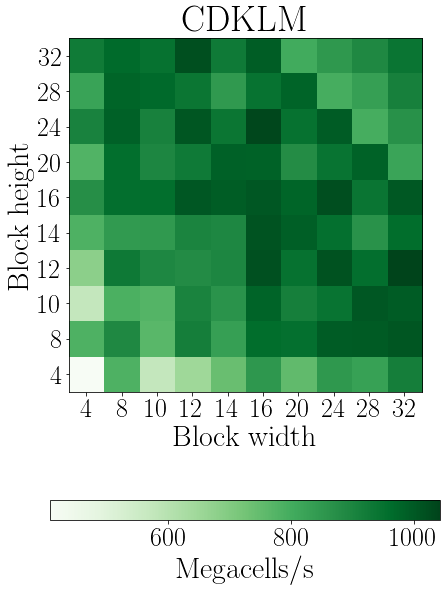

In [6]:
simulators = np.unique(data[:,0])
block_widths = np.unique(data[:,1])
block_heights = np.unique(data[:,2])

print(block_widths)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for simulator in simulators:
    print(simulator)
    
    df = pd.DataFrame(index=block_widths, columns=block_heights)

    # Pick this simulator data only and sort into a dataframe
    columns = data[:,0] == simulator
    for record in data[columns]:
        block_width = record[1]
        block_height = record[2]
        megacells = np.float32(record[3])
        df[block_height][block_width] = megacells
        
    maximum = np.nanmax(df.values)
    minimum = np.nanmin(df.values)
    mean = np.nanmean(df.values)
    print(df)
    print("Maximum={:.2f}".format(maximum))
    print("Minimum={:.2f}".format(minimum))
    print("Mean={:.2f}".format(mean))

    # Plot dataframe
    x = df.index.values.astype(np.int)
    y = df.columns.values.astype(np.int)
    z = np.transpose(df.values.astype(np.float32))
    
    fontsize=30
    fig = plt.figure(figsize=(7,10))
    ax = fig.add_subplot(111)
    img = ax.imshow(z, origin='lower', cmap=cm.Greens, interpolation="None")
    
    plt.xticks( range(len(x)), x, fontsize=fontsize-4)
    ax.set_xlabel('Block width', fontsize=fontsize)
    plt.yticks( range(len(y)), y, fontsize=fontsize-4)
    ax.set_ylabel('Block height', fontsize=fontsize)

    cb = plt.colorbar(img, orientation="horizontal", pad=0.2)
    cb.ax.tick_params(labelsize=fontsize-4)
    #cb.ax.set_ylabel('Megacells/s')#, rotation=270)
    cb.set_label('Megacells/s', fontsize=fontsize)#, labelpad=-40, y=0.45)



    
    #plt.title(simulator + " [megacells/s]", fontsize=fontsize+6)
    plt.title(simulator, fontsize=fontsize+6)
    fig.savefig(test_filename.replace('.txt', '_'+simulator+'.pdf'))
    print(fig.get_size_inches())

In [7]:
print(test_filename.replace('.txt', '_cdklm.pdf'))

blocksize_benchmark_run_1_cdklm.pdf
